## Import libraries

In [1]:
# Import libraries
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score

from scipy import interp
from itertools import cycle

## Definition of functions

In [2]:
def metrics_df(actual_values,predictions):
    precision = pd.DataFrame(precision_score(actual_values, predictions,average=None))
    recall = pd.DataFrame(recall_score(actual_values, predictions,average=None))
    f1 = pd.DataFrame(f1_score(actual_values, predictions, average=None))

    metrics = pd.concat([precision, recall, f1], axis=1)
    metrics.index = ['A','D','H']
    metrics.columns = ['precision', 'recall', 'f1_score']
    metrics.columns.name = 'FTR'
    return metrics

In [3]:
def roc_curve_multiclass(n_classes,X_train, X_test, y_train, y_test,y_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # First aggregate all false positive rates


    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

In [4]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## Explore dataset

* I'm going to work with a dataset that contain all results of all matches since the season 2010-2011

In [5]:
laLiga = pd.read_csv('laLiga_csv.csv')
laLiga.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,...,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,2017-08-18,Leganes,Alaves,1,0,H,1,0,H,16,...,9,3,14,18,4,2,0,1,0,0
1,2017-08-18,Valencia,Las Palmas,1,0,H,1,0,H,22,...,6,4,25,13,5,2,3,3,0,1
2,2017-08-19,Celta,Sociedad,2,3,A,1,1,D,16,...,5,6,12,11,5,4,3,1,0,0
3,2017-08-19,Girona,Ath Madrid,2,2,D,2,0,H,13,...,6,3,15,15,6,0,2,4,0,1
4,2017-08-19,Sevilla,Espanol,1,1,D,1,1,D,9,...,4,6,14,12,7,3,2,4,1,0


In [6]:
laLiga.dtypes

Date        object
HomeTeam    object
AwayTeam    object
FTHG         int64
FTAG         int64
FTR         object
HTHG         int64
HTAG         int64
HTR         object
HS           int64
AS           int64
HST          int64
AST          int64
HF           int64
AF           int64
HC           int64
AC           int64
HY           int64
AY           int64
HR           int64
AR           int64
dtype: object

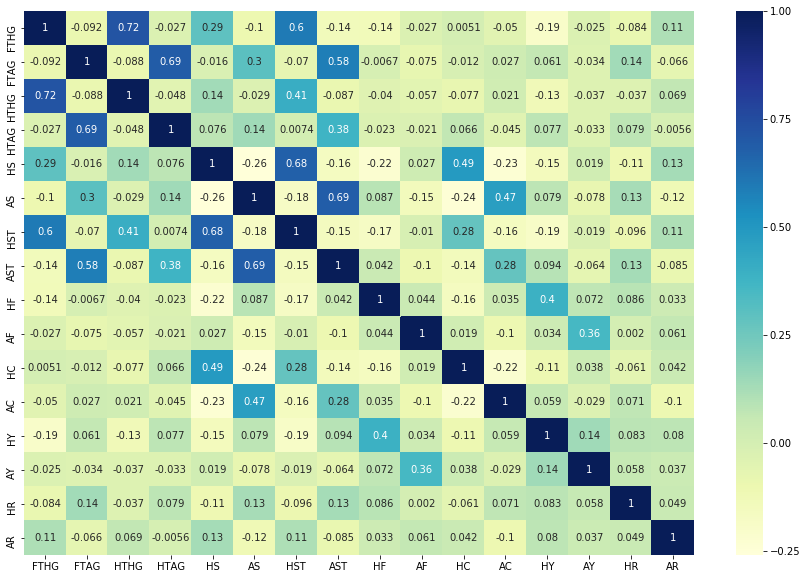

In [7]:
# Obtain correlation
corr = laLiga.corr()
# plot the heatmap (correlation matrix)
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(ax=ax,data=corr, xticklabels=corr.columns, yticklabels=corr.columns,annot=True,cmap="YlGnBu")

* If I establish a correlation threshold in 90%, we can see that this dataset don't contains columns that are correlated for over 90%. So I can't drop any column.

## Handle Missing Values


In [8]:
laLiga.isnull().sum(axis = 0)

Date        0
HomeTeam    0
AwayTeam    0
FTHG        0
FTAG        0
FTR         0
HTHG        0
HTAG        0
HTR         0
HS          0
AS          0
HST         0
AST         0
HF          0
AF          0
HC          0
AC          0
HY          0
AY          0
HR          0
AR          0
dtype: int64

* We can see in the cell above that there aren't null values 

## I'm going to work with Real Madrid matches at home

In [9]:
#Obtain dummies of Real Madrid when play at home
laLiga_madrid = laLiga[laLiga['HomeTeam'] == 'Real Madrid']

y = pd.get_dummies(data=laLiga_madrid.FTR)
X = laLiga_madrid.loc[:, laLiga_madrid.columns != 'FTR']

In [10]:
X.drop(['Date','HomeTeam','AwayTeam','HTR'],axis=1,inplace=True)

/home/luis/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
X_train.head()

,FTHG,FTAG,HTHG,HTAG,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
925,3,1,1,0,23,13,13,2,12,9,13,2,1,4,0,0
2692,3,0,1,0,20,9,7,3,15,11,8,5,2,2,1,2
2233,4,3,2,2,27,14,11,6,7,10,7,10,1,3,0,0
19,2,2,1,1,22,7,6,3,12,12,13,4,3,5,0,0
1567,4,1,2,1,29,7,11,4,13,15,9,5,1,3,0,1


## Cross validation of some models and accuracy

In [12]:
# Your code here:
##MODELS
cls_LogisticRegression = OneVsRestClassifier(LogisticRegression(solver="lbfgs"))
scores = cross_val_score(cls_LogisticRegression, X, y, cv=5)
print("'LogisticRegression' -> Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
#-------------------------------------------------
cls_LinearRegression = OneVsRestClassifier(linear_model.LinearRegression())
scores = cross_val_score(cls_LinearRegression, X, y, cv=5)
print("'LinearRegression' -> Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
#-------------------------------------------------
cls_RandomForestClassifier = OneVsRestClassifier(RandomForestClassifier(n_estimators=20))
scores = cross_val_score(cls_RandomForestClassifier, X, y, cv=5)
print("'RandomForestClassifier' -> Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
#-------------------------------------------------
cls_SVC = OneVsRestClassifier(svm.SVC(gamma="auto"))
scores = cross_val_score(cls_SVC, X, y, cv=5)
print("'SVC' -> Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
#-------------------------------------------------
cls_LinearSVC = OneVsRestClassifier(svm.LinearSVC())
scores = cross_val_score(cls_LinearSVC, X, y, cv=5)
print("'LinearSVC' -> Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
#-------------------------------------------------
cls_KNeighborsClassifier = KNeighborsClassifier(n_neighbors=5)  
scores = cross_val_score(cls_KNeighborsClassifier, X, y, cv=5)
print("'KNeighborsClassifier' -> Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

/home/luis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/luis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/luis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/luis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/luis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.


'LogisticRegression' -> Accuracy: 0.84 (+/- 0.20)
'LinearRegression' -> Accuracy: 0.81 (+/- 0.10)
'RandomForestClassifier' -> Accuracy: 0.85 (+/- 0.09)
'SVC' -> Accuracy: 0.81 (+/- 0.12)
'LinearSVC' -> Accuracy: 0.83 (+/- 0.19)
'KNeighborsClassifier' -> Accuracy: 0.84 (+/- 0.11)


/home/luis/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/luis/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/luis/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/luis/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/luis/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
 

## Train with RandomForestClassifier model because in the cell above I have obtained the best accuracy

In [13]:
cls_RandomForestClassifier = OneVsRestClassifier(RandomForestClassifier(n_estimators=20))
cls_RandomForestClassifier.fit(X_train,y_train)
print("Score: {}".format(cls_RandomForestClassifier.score(X_test,y_test)))

Score: 0.8125


## Accuracy score

In [14]:
y_pred=cls_RandomForestClassifier.predict(X_test)
print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))

Accuracy: 0.8125


In [15]:
actual_values = y_test.values.argmax(axis=1)
predictions = cls_RandomForestClassifier.predict(X_test).argmax(axis=1)
print(actual_values)

[2 2 2 2 2 2 0 2 1 2 1 2 1 2 2 0]


In [16]:
accuracy = accuracy_score(actual_values, predictions)
print("Accuracy Score: {}".format(accuracy))

Accuracy Score: 0.8125


In [17]:
metrics_df(actual_values,predictions)

FTR,precision,recall,f1_score
A,0.333333,0.500000,0.400000
D,1.000000,0.333333,0.500000
H,0.916667,1.000000,0.956522


## Confusion Matrix

Confusion matrix, without normalization
[[ 1  0  1]
 [ 2  1  0]
 [ 0  0 11]]


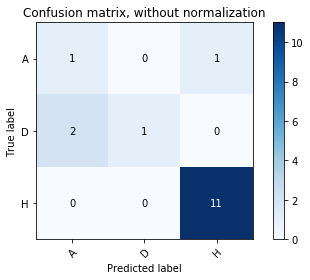

In [18]:
plot_confusion_matrix(actual_values, predictions, y.columns)

## Roc Curve of RandomForestClassifier model

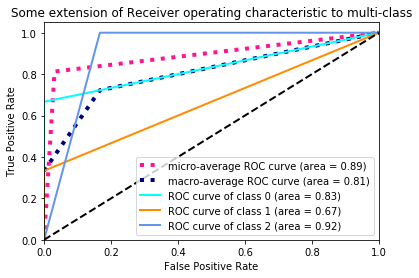

In [19]:
lw = 2

y_rf = label_binarize(y, classes=['A', 'D', 'H'])
n_classes = y.shape[1]
# Compute macro-average ROC curve and ROC area
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X, y_rf, test_size=0.1, shuffle=True)

cls_RandomForestClassifier = OneVsRestClassifier(RandomForestClassifier(n_estimators=20))
cls_RandomForestClassifier.fit(X_train_rf,y_train_rf)
y_score=cls_RandomForestClassifier.predict(X_test_rf)
roc_curve_multiclass(n_classes,X_train_rf, X_test_rf, y_train_rf, y_test_rf,y_score)

## Train with RandomForestClassifier model because in the cell above I have obtained the best accuracy

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
cls_KNeighborsClassifier = KNeighborsClassifier(n_neighbors=5)
cls_KNeighborsClassifier.fit(X_train,y_train)
print("Score: {}".format(cls_KNeighborsClassifier.score(X_test,y_test)))

Score: 0.8125


## Accuracy score

In [21]:
y_pred=cls_KNeighborsClassifier.predict(X_test)
print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))

Accuracy: 0.8125


In [22]:
actual_values_knn = y_test.values.argmax(axis=1)
predictions_knn = cls_KNeighborsClassifier.predict(X_test).argmax(axis=1)
print(actual_values_knn)

[2 2 2 2 2 1 2 2 0 2 1 2 2 2 2 2]


In [23]:
accuracy = accuracy_score(actual_values_knn, predictions_knn)
print("Accuracy Score: {}".format(accuracy))

Accuracy Score: 0.8125


In [24]:
metrics_df(actual_values_knn,predictions_knn)

/home/luis/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/luis/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


FTR,precision,recall,f1_score
A,0.0000,0.0,0.000000
D,0.0000,0.0,0.000000
H,0.8125,1.0,0.896552


## Confusion Matrix

Confusion matrix, without normalization
[[ 0  0  2]
 [ 0  0  3]
 [ 0  0 11]]


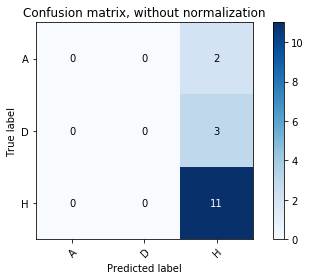

In [25]:
plot_confusion_matrix(actual_values, predictions_knn, y.columns)

## Roc Curve of KNeighborsClassifier model

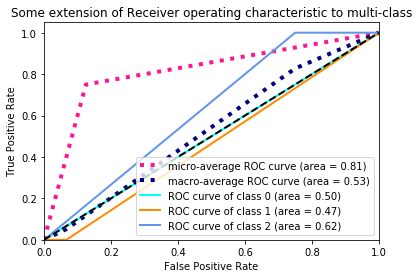

In [26]:
lw = 2

y_KN = label_binarize(y, classes=['A', 'D', 'H'])
n_classes = y.shape[1]
# Compute macro-average ROC curve and ROC area
X_train_KN, X_test_KN, y_train_KN, y_test_KN = train_test_split(X, y_KN, test_size=0.1, shuffle=True)

cls_KNeighborsClassifier = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=5))
cls_KNeighborsClassifier.fit(X_train_KN,y_train_KN)
y_score=cls_KNeighborsClassifier.predict(X_test_KN)
roc_curve_multiclass(n_classes,X_train_KN, X_test_KN, y_train_KN, y_test_KN,y_score)